# TranscriptHomies 🧬🤝
#### <span style="color: blue;">_Explore how genes work together. This tool maps gene–gene expression correlations within your dataset, helping you discover coordinated expression patterns and visualize network structures that define biological systems._</span>
#### **Team Members:** Grace Beggs, Caroline Harrer, HeaJin Hong, Tess Kelly, Zilin Xianyu
#### **TAs:** Riley Kellermeyer, Bekah Kim

# **Data Input and Organization**

# **Analysis**

### <span style="color: blue;">PyDESeq2: Differential gene expression analysis based on the negative binomial distribution.</span>

#### Section 1: Import Libraries and Set Parameters

In [ ]:
# Breast Cancer DESeq2 Paired Analysis
# This notebook performs differential expression analysis comparing tumor (C) vs normal (CP) breast tissue samples using a paired design.

import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Hardcoded parameters
file = "GSE280284_Processed_data_files.txt"
cond1 = "C"
cond2 = "CP"

#### Section 2: Load Expression Data

In [ ]:
print(f"📂 Reading file: {file}")
df = pd.read_csv(file, sep="\t", index_col=0)

# Save annotation columns if they exist
gene_symbols = df["symbol"] if "symbol" in df.columns else None
gene_names = df["name"] if "name" in df.columns else None

# Drop annotation columns before DESeq2
drop_cols = [c for c in ["symbol", "name"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Select relevant samples (ending with cond1 or cond2)
samples = [c for c in df.columns if c.endswith(cond1) or c.endswith(cond2)]
counts = df[samples]

print(f"Loaded {len(counts)} genes across {len(samples)} samples")

#### Section 3: Set Exclusion Criteria and Filter Low-Count Genes

In [ ]:
# Section 3: Filter Low-Count Genes

# Filtering criteria: keep genes with >= 10 counts in >= 3 samples
MIN_COUNTS = 10
MIN_SAMPLES = 3

# Identify genes that pass the filter
genes_pass_filter = (counts >= MIN_COUNTS).sum(axis=1) >= MIN_SAMPLES
filtered_counts = counts[genes_pass_filter]
removed_genes = counts[~genes_pass_filter]

# Save removed genes
removed_file = f"removed_low_count_genes_{cond1}_vs_{cond2}.txt"
removed_genes.to_csv(removed_file, sep="\t")

print(f"\n🧹 Gene Filtering Summary:")
print(f"   Total genes before filtering: {len(counts)}")
print(f"   Genes passing filter (>={MIN_COUNTS} counts in >={MIN_SAMPLES} samples): {len(filtered_counts)}")
print(f"   Genes removed: {len(removed_genes)}")
print(f"   Percentage kept: {len(filtered_counts)/len(counts)*100:.1f}%")
print(f"📁 Saved list of removed genes to: {removed_file}")

#### Section 4: Extract Patient IDs and Build Metadata 

In [ ]:
# Helper: extract patient ID robustly
def extract_patient_id(s, cond1, cond2):
    """Strip condition suffix and normalize IDs with or without trailing zeros."""
    if s.endswith(cond2):
        base = s[: -len(cond2)]
    elif s.endswith(cond1):
        base = s[: -len(cond1)]
    else:
        base = s
    if base.endswith("0") and (base[:-1] + cond2) in df.columns:
        base = base[:-1]
    return base

# Build metadata with patient IDs
patients = [extract_patient_id(s, cond1, cond2) for s in filtered_counts.columns]
meta = pd.DataFrame({
    "sample": filtered_counts.columns,
    "patient": patients,
    "condition": [cond1 if s.endswith(cond1) else cond2 for s in filtered_counts.columns]
}, index=filtered_counts.columns)

print("Metadata created:")
print(meta.head())

#### Section 5: Check and Verify Tumor-Normal Pairing

In [ ]:
print("\n🔍 Checking detected tumor-normal pairs:")
tumor_samples = [s for s in filtered_counts.columns if s.endswith(cond1)]
normal_samples = [s for s in filtered_counts.columns if s.endswith(cond2)]
paired_patients, missing_pairs = [], []
for t in tumor_samples:
    pid = extract_patient_id(t, cond1, cond2)
    n_candidates = [n for n in normal_samples if extract_patient_id(n, cond1, cond2) == pid]
    if n_candidates:
        print(f"  ✅ {t}  ↔  {n_candidates[0]}")
        paired_patients.append(pid)
    else:
        print(f"  ⚠️  Missing normal pair for tumor sample: {t}")
        missing_pairs.append(pid)
for n in normal_samples:
    pid = extract_patient_id(n, cond1, cond2)
    t_candidates = [t for t in tumor_samples if extract_patient_id(t, cond1, cond2) == pid]
    if not t_candidates:
        print(f"  ⚠️  Missing tumor pair for normal sample: {n}")
        missing_pairs.append(pid)
# Keep only complete pairs
if missing_pairs:
    print(f"\n⚠️ Warning: {len(missing_pairs)} unmatched samples detected. Only complete pairs will be used.")
    paired_patients = list(set(paired_patients))
    meta = meta[meta["patient"].isin(paired_patients)]
    filtered_counts = filtered_counts[meta.index]
else:
    print("\n✅ All pairs detected successfully.")

#### Section 6: Run DESeq2 Paired Analysis

In [ ]:
print("\n⚙️ Running DESeq2 paired analysis...")
dds = DeseqDataSet(
    counts=filtered_counts.T,
    metadata=meta[["patient", "condition"]],
    design_factors=["patient", "condition"]
)
dds.deseq2()

print("✅ DESeq2 model fitting complete!")

#### Section 7: Compute Differential Expression Statistics

In [ ]:
stat_res = DeseqStats(dds, contrast=["condition", cond1, cond2])
stat_res.summary()

print("✅ Statistical testing complete!")

#### Section 8: Combine Results with Gene Annotations

In [ ]:
results = stat_res.results_df.copy()
results.index.name = "ensembl_id"

if gene_symbols is not None:
    results = results.merge(gene_symbols, left_index=True, right_index=True, how="left")
if gene_names is not None:
    results = results.merge(gene_names, left_index=True, right_index=True, how="left")

print(f"Results table created with {len(results)} genes")
print("\nFirst few results:")
print(results.head())

#### Section 9: Save All Results

In [ ]:
# Save all results (tab-delimited)
out_file = f"DE_{cond1}_vs_{cond2}_paired_filtered.txt"
results.to_csv(out_file, sep="\t")
print(f"📊 All results saved to: {out_file}")

#### Section 10: Save Significant Results

In [ ]:
sig_results = results[results["padj"] < 0.05].sort_values("padj")
sig_file = f"DE_{cond1}_vs_{cond2}_paired_filtered_significant.txt"
sig_results.to_csv(sig_file, sep="\t")
print(f"✨ Significant genes (padj < 0.05) saved to: {sig_file}")
print(f"🔬 Significant genes found: {len(sig_results)}")

#### Section 11: Save Top 20 Genes

In [ ]:
# Top 20 genes
top20_file = f"DE_{cond1}_vs_{cond2}_paired_filtered_top20.txt"
top20 = sig_results.head(20)
top20.to_csv(top20_file, sep="\t")
print(f"🏆 Top 20 genes saved to: {top20_file}")
print("\nTop 20 most significant genes:")
print(top20[["symbol", "log2FoldChange", "padj"]].head(20))

#### Section 12: Save Filtered Counts with Annotations

In [ ]:
# Save filtered counts with gene annotations
filtered_counts_with_annotations = filtered_counts.copy()
if gene_symbols is not None:
    filtered_counts_with_annotations = filtered_counts_with_annotations.merge(
        gene_symbols, left_index=True, right_index=True, how="left"
    )
if gene_names is not None:
    filtered_counts_with_annotations = filtered_counts_with_annotations.merge(
        gene_names, left_index=True, right_index=True, how="left"
    )
filtered_counts_with_annotations.to_csv('final_input_filtered.csv', index=True)
print(f"📁 Filtered count matrix saved to: final_input_filtered.csv")

#### Section 13: Final Summary 

In [ ]:
print(f"\n✅ DESeq2 Analysis Complete!")
print(f"🧬 Total genes analyzed: {len(results)}")
print(f"🔬 Significant genes found: {len(sig_results)}")
print(f"\n📂 Output files created:")
print(f"   • {out_file}")
print(f"   • {sig_file}")
print(f"   • {top20_file}")
print(f"   • final_input_filtered.csv")
print(f"   • {removed_file}")

### <span style="color: blue;">Correlation Analysis</span>

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr
from scipy.stats import false_discovery_control


# input 1: gene expression matrix (genes x samples)
df = pd.read_csv("final_input_filtered.csv", index_col=0)
print(df.head())

                 1622003800C  1621001800C  1622003500C  1621003700C  \
gene_id                                                               
NONHSAG104656.1            8           12           15           42   
ENSG00000198692           14            5            5           14   
NONHSAG104654.1            8            3            0            4   
NONHSAG115270.1           18           14            5           13   
NONHSAG104622.1            9            9           82           12   

                 1621002900C  1621002200C  162200380CP  162100180CP  \
gene_id                                                               
NONHSAG104656.1            7           14           18            6   
ENSG00000198692           12           21           15            6   
NONHSAG104654.1            2            9            6           10   
NONHSAG115270.1           10           14            7           16   
NONHSAG104622.1           63           11           31            8   

    

In [3]:
# Split data: all but last two columns for normalization
df_main = df.iloc[:, :-2]     # everything except last 2 columns
df_extra = df.iloc[:, -2:]    # last 2 columns kept as-is

# Convert to float and normalize
df_main = df_main.astype(float)
df_z = df_main.apply(lambda x: zscore(x), axis=1, result_type='broadcast')

# Rejoin
df_final = pd.concat([df_z, df_extra], axis=1)

# Replace rowname with second-to-last column
df_final.index = df.iloc[:, -2]
# get rid of last two columns
df_final = df_final.iloc[:, :-2]
print(df_final.head())

        1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                    
-         -0.876549    -0.504209    -0.224955     2.288335    -0.969633   
EIF1AY     0.500639    -1.430397    -1.430397     0.500639     0.071520   
-          0.475744    -1.026605    -1.928015    -0.726135    -1.327075   
-          0.979816     0.221249    -1.485528     0.031607    -0.537319   
-         -0.720726    -0.720726     2.516997    -0.587669     1.674302   

        1621002200C  162200380CP  162100180CP  162200350CP  162100370CP  \
symbol                                                                    
-         -0.318040     0.054299    -1.062718     1.822911     0.054299   
EIF1AY     2.002556     0.715199    -1.215838     0.286079    -0.357599   
-          0.776214    -0.125196     1.076684    -0.125196     0.776214   
-          0.221249    -1.106244     0.600533    -1.485528     2.117667   
-         -0.632021     

In [6]:
# input 2: pathway
pathway = pd.read_csv("lin/GO_pathways_genes.csv")

poi = "GOBP_CYTOKINESIS"
genes_in_pathway = pathway.loc[pathway['Pathway'] == poi, 'Gene'].tolist()
print(f"Genes in pathway {poi}: {genes_in_pathway}")

# filter df_final to include only genes in the pathway
df_poi = df_final.loc[df_final.index.isin(genes_in_pathway)]
print("Filtered expression DataFrame:\n", df_poi.head(), "\n")


Genes in pathway GOBP_CYTOKINESIS: ['ACTR2', 'ACTR3', 'AHCTF1', 'ALKBH4', 'ANK3', 'ANKRD53', 'ANLN', 'ANXA11', 'APC', 'ARF1', 'ARF6', 'ARL3', 'ATXN10', 'AURKA', 'AURKB', 'AURKC', 'BBS4', 'BCL2L1', 'BECN1', 'BIN3', 'BIRC5', 'BIRC6', 'BRCA2', 'CALM1', 'CALM2', 'CALM3', 'CCDC66', 'CCP110', 'CDC14A', 'CDC14B', 'CDC14C', 'CDC25B', 'CDC42', 'CDC6', 'CDCA8', 'CECR2', 'CENPA', 'CENPV', 'CEP55', 'CETN2', 'CFL1', 'CHMP1A', 'CHMP1B', 'CHMP2A', 'CHMP2B', 'CHMP3', 'CHMP4A', 'CHMP4B', 'CHMP4BP1', 'CHMP4C', 'CHMP5', 'CHMP6', 'CHMP7', 'CIT', 'CKAP2', 'CNTROB', 'CSPP1', 'CUL3', 'CUL7', 'CXCR5', 'DCDC1', 'DCTN3', 'DRD2', 'DRD3', 'E2F7', 'E2F8', 'ECT2', 'EFHC1', 'ENTR1', 'ESPL1', 'EXOC1', 'EXOC2', 'EXOC3', 'EXOC4', 'EXOC5', 'EXOC6', 'EXOC6B', 'EXOC7', 'EXOC8', 'FMN2', 'FSD1', 'GIPC1', 'GIT1', 'INCENP', 'IQGAP1', 'IQGAP2', 'IQGAP3', 'IST1', 'JTB', 'KIF13A', 'KIF14', 'KIF20A', 'KIF20B', 'KIF23', 'KIF3B', 'KIF4A', 'KIF4B', 'KLHDC8B', 'KLHL13', 'KLHL21', 'KLHL9', 'LUZP1', 'LZTS2', 'MAP10', 'MAP9', 'MITD1', '

In [8]:
# Split columns by substring
nm_cols = [c for c in df_poi.columns if "0CP" in c]
ds_cols = [c for c in df_poi.columns if "P" not in c]

# Create two separate DataFrames
df_nm = df_poi[nm_cols]
df_ds = df_poi[ds_cols]

print("NM subset:\n", df_nm.head(), "\n")
print("DS subset:\n", df_ds.head(), "\n")

NM subset:
          162200380CP  162100180CP  162200350CP  162100370CP  162100290CP  \
symbol                                                                     
CETN2      -0.333385     0.206491    -1.368841     0.115128    -0.732063   
SEPTIN6    -0.774774    -0.097936    -0.791695    -0.410205    -0.797848   
KLHL13      2.237504     1.482906    -0.269830     0.926422    -0.141119   
KIF4A      -1.126768    -0.557018    -1.034462    -0.907144    -1.120402   
ATXN10     -0.139306     2.057496    -0.789886     1.208532    -0.188902   

         162100220CP  
symbol                
CETN2      -0.164501  
SEPTIN6    -0.699399  
KLHL13      0.292964  
KIF4A      -0.716166  
ATXN10      0.814684   

DS subset:
          1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0

In [9]:
expression_df = df_ds # using only NM samples for correlation
name = "DS"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] 
print(expression_df)

         1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0.760930     2.057177   
KLHL13     -0.658485    -0.406111    -0.854075    -0.556274    -1.101401   
KIF4A       1.008998     0.464712     1.970252     0.773459     0.989901   
ATXN10     -0.083875    -0.113049     0.797179    -1.285844    -0.962012   
...              ...          ...          ...          ...          ...   
BECN1      -1.636028    -0.412575    -0.954973     0.545796    -1.831781   
ACTR2       1.391849     1.023247     0.203196     1.341849     1.289815   
SEPTIN9    -0.642075     0.331555    -0.168986     2.938003    -0.609633   
BIRC5       0.338088    -0.099608    -0.058114     0.667364     3.008437   
CHMP6      -1.145599     0.499249    -0.182761     0.218422    -1.814236   

         16

In [10]:
# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
# explain why FDR correction is needed
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

print("Pearson Correlation Matrix:")
print(pearson_corr)
print("Pearson FDR Matrix:")
print(pearson_fdr)
print("Spearman Correlation Matrix:")
print(spearman_corr)
print("Spearman FDR Matrix:")
print(spearman_fdr) 


Pearson Correlation Matrix:
symbol      CETN2   SEPTIN6    KLHL13     KIF4A    ATXN10   SEPTIN5     CECR2  \
symbol                                                                          
CETN2    1.000000  0.189916  0.356430  0.422064  0.277020  0.500771  0.430316   
SEPTIN6  0.189916  1.000000 -0.225565  0.161438  0.241762  0.669487 -0.568893   
KLHL13   0.356430 -0.225565  1.000000 -0.226313  0.194034  0.420591  0.428719   
KIF4A    0.422064  0.161438 -0.226313  1.000000  0.739218  0.408510 -0.158160   
ATXN10   0.277020  0.241762  0.194034  0.739218  1.000000  0.724720 -0.461109   
...           ...       ...       ...       ...       ...       ...       ...   
BECN1   -0.202966 -0.935441  0.391484 -0.466774 -0.447107 -0.654450  0.654689   
ACTR2    0.519959  0.526433  0.353661 -0.138329 -0.210237  0.475127  0.360540   
SEPTIN9  0.334631 -0.573671  0.551301 -0.086305 -0.305725 -0.191849  0.948233   
BIRC5   -0.096748  0.562024 -0.560315  0.067378 -0.358177 -0.017880 -0.072252   


In [11]:
# Define FDR significance threshold
fdr_threshold = 0.05

# Count significant gene–gene pairs (excluding self-pairs)
pearson_sig = np.sum((pearson_fdr < fdr_threshold).values) - len(genes)
spearman_sig = np.sum((spearman_fdr < fdr_threshold).values) - len(genes)

print(f"Significant Pearson pairs (FDR<{fdr_threshold}): {pearson_sig}")
print(f"Significant Spearman pairs (FDR<{fdr_threshold}): {spearman_sig}")

# Compare counts
# highlight pearson vs spearman choosen method
if pearson_sig > spearman_sig:
    chosen_method = "pearson"
elif spearman_sig > pearson_sig:
    chosen_method = "spearman"
else:
    # Tie → compare average |r²|
    pearson_r2 = np.nanmean(np.square(pearson_corr.values))
    spearman_r2 = np.nanmean(np.square(spearman_corr.values))
    chosen_method = "pearson" if pearson_r2 > spearman_r2 else "spearman"

print(f"Chosen method: {chosen_method.upper()}")

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")


Significant Pearson pairs (FDR<0.05): 46
Significant Spearman pairs (FDR<0.05): 144
Chosen method: SPEARMAN


## **Output and Visualization**

### Part 1: Net graph

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Example transition matrix
data = {
    "GeneA": [0.0, 0.5, 0.2, 0.1, 0.05, 0.0, 0.0],
    "GeneB": [0.5, 0.0, 0.5, 0.2, 0.1, 0.1, -0.3],
    "GeneC": [0.2, 0.5, 0.0, 0.4, -0.2, -0.1, 0.3],
    "GeneD": [0.1, 0.2, 0.4, 0.0, 0.2, 0.2, 0.0],
    "GeneE": [0.05, 0.1, -0.2, 0.2, 0.0, 0.3, 0.25],
    "GeneF": [0.0, 0.1, -0.1, 0.2, 0.3, 0.0, 0.0],
    "GeneG": [0.0, -0.3, 0.3, 0.0, 0.25, 0.0, 0.0]
}

transition_df = pd.DataFrame(data, index=["GeneA", "GeneB", "GeneC", "GeneD","GeneE","GeneF","GeneG"])


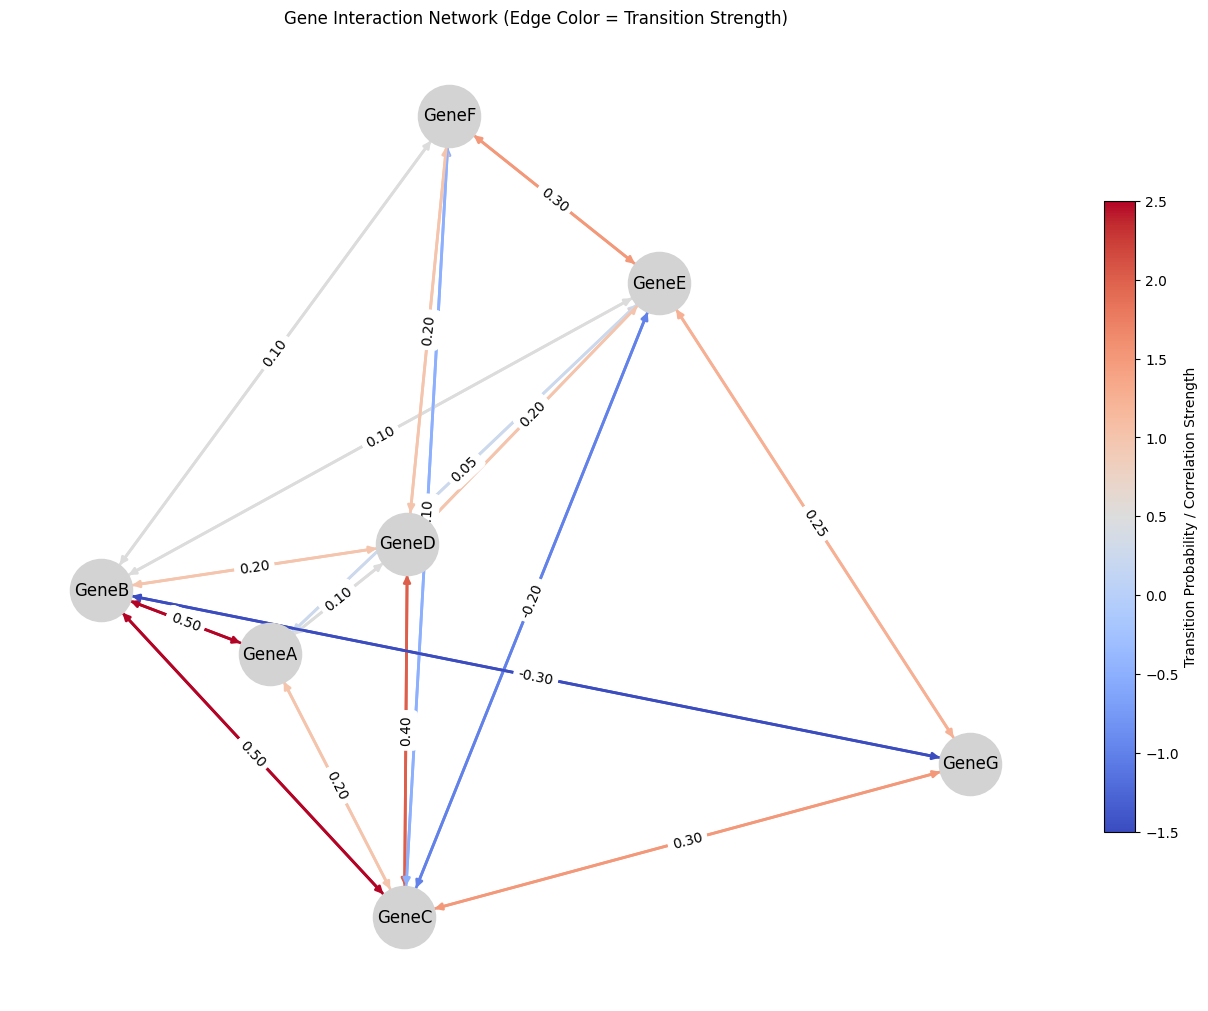

In [13]:
G = nx.DiGraph()

# Add edges with weights (probabilities)
for from_gene in transition_df.index:
    for to_gene in transition_df.columns:
        weight = transition_df.loc[from_gene, to_gene]
        if abs(weight) > 0:
            G.add_edge(from_gene, to_gene, weight=weight)

# Define layout (spring_layout or circular_layout)
pos = nx.spring_layout(G, seed=42)

# Get edge weights
weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # scale up for visibility

cmap = plt.cm.coolwarm

# Normalize weights between 0 and 1 for colormap scaling
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
edge_colors = [cmap(norm(w)) for w in weights]

fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="lightgrey",
    edge_color=edge_colors,
    width=2,
    font_size=12,
    arrows=True,
    ax=ax
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Transition Probability / Correlation Strength")

edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black", font_size=10, ax=ax)

plt.title("Gene Interaction Network (Edge Color = Transition Strength)")
plt.show()